### **"dl4td_keras_tuner_2"**

#### **Libraries Used:**
- pandas
- numpy
- matplotlib.pyplot
- scikit-learn
- TensorFlow (imported as keras)
- Kerastuner (RandomSearch)

#### **Data Preparation:**
- Loaded dataset from "../data/drinking_water_potability.csv".
- Imported custom module "data_cleaning" for data cleaning.
- Cleaned data using function "clean_data" from "data_cleaning" module.
- Defined features and labels.
- Split data into train and test sets (test_size=0.2, random_state=42).
- Standardized features using StandardScaler.

#### **Model Building:**
- Defined function "build_model" to construct model architecture using Kerastuner's hyperparameters.
- Built a Sequential model with varying number of dense layers (2 to 25).
- Utilized ReLU, tanh, or sigmoid activation functions for hidden layers.
- Added BatchNormalization and Dropout layers based on hyperparameters.
- Compiled the model with binary crossentropy loss function and Adam optimizer with varying learning rates (1e-2, 1e-3, 1e-4).

#### **Hyperparameter Tuning:**
- Utilized RandomSearch tuner to search for the best model based on validation accuracy.
- Specified maximum trials (10) and executions per trial (5).
- Saved results in the directory 'my_dir2' under the project name 'test1_water_potability'.

#### **Model Training:**
- Conducted a search for the best model using the training data (X_train, y_train).
- Trained each model for 50 epochs with early stopping based on validation loss.

#### **Results Summary:**
- Evaluated the best models on the test data and stored the results in a DataFrame.
- Plotted the training accuracy and loss of the best model.

---------

## Load libraries

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

## Load dataset

In [3]:
df = pd.read_csv('../data/drinking_water_potability.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890456,20791.31898,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.05786,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.54173,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.41744,8.059332,356.886136,363.266516,18.436525,100.341674,4.628771,0
4,9.092223,181.101509,17978.98634,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681736,47580.99160,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.80216,8.061362,333.775777,392.449580,19.903225,66.396293,2.798243,1
3273,9.419510,175.762646,33155.57822,7.350233,333.775777,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.86938,6.303357,333.775777,402.883113,11.168946,77.488213,4.708658,1


## Data Preparation

In [5]:
import sys
sys.path.append("../modules")  # Add parent directory to path if necessary

# Now you can import the module or function
import data_cleaning

# Then you can call the desired function
df_cleang = data_cleaning.clean_data(df)


In [6]:
# Check for missing values
df_cleang.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [7]:
# Define features and labels
features = df.columns[:-1]
labels = df.columns[-1]

In [8]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[labels], test_size=0.2, random_state=42)

In [9]:
# Initialize StandardScaler
scaler = StandardScaler()

# Scale features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Model Building:

In [10]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units_0',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           input_shape=(X_train.shape[1],),
                           activation='relu'))
    for i in range(1, hp.Int('num_layers', 2, 25)):
        model.add(layers.Dense(units=hp.Int(f'units_{i}',
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation=hp.Choice(f'activation_{i}',
                                                   values=['relu', 'tanh', 'sigmoid'])))
        if hp.Choice('bath_norm', [True, False]):
            model.add(layers.BatchNormalization())
        if hp.Choice('dropout', [True, False]):
            model.add(layers.Dropout(rate=hp.Float(f'dropout_{i}',
                                                   min_value=0.0,
                                                   max_value=0.5,
                                                   default=0.25,
                                                   step=0.05)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    return model

In [13]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=10,
    directory='my_dir2',
    project_name='test1_water_potability')


In [14]:
tuner.search_space_summary

<bound method BaseTuner.search_space_summary of <keras_tuner.src.tuners.randomsearch.RandomSearch object at 0x000002DB0113B5B0>>

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [16]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 20 Complete [00h 03m 35s]
val_accuracy: 0.6068702280521393

Best val_accuracy So Far: 0.6770992338657379
Total elapsed time: 00h 54m 37s


In [17]:
tuner.results_summary()

Results summary
Results in my_dir2\test1_water_potability
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 15 summary
Hyperparameters:
units_0: 512
num_layers: 2
units_1: 256
activation_1: relu
bath_norm: 1
dropout: 0
dropout_1: 0.15000000000000002
learning_rate: 0.01
units_2: 416
activation_2: tanh
units_3: 352
activation_3: tanh
units_4: 32
activation_4: tanh
units_5: 64
activation_5: relu
units_6: 416
activation_6: relu
units_7: 416
activation_7: relu
units_8: 64
activation_8: sigmoid
units_9: 256
activation_9: sigmoid
units_10: 192
activation_10: tanh
dropout_2: 0.4
dropout_3: 0.15000000000000002
dropout_4: 0.30000000000000004
dropout_5: 0.30000000000000004
dropout_6: 0.30000000000000004
units_11: 416
activation_11: tanh
units_12: 64
activation_12: tanh
units_13: 224
activation_13: tanh
units_14: 256
activation_14: tanh
units_15: 192
activation_15: relu
units_16: 256
activation_16: sigmoid
units_17: 192
activation_17: tanh
units_18: 352
activation_18: r

In [18]:
# Get the best models found during the search
models = tuner.get_best_models(num_models=len(tuner.oracle.trials))

# Evaluate each model on the test data and store the scores
model_scores = [model.evaluate(X_test, y_test) for model in models]


21/21 [==============================] - 2s 6ms/step - loss: 0.6834 - accuracy: 0.6143


In [23]:
# Create a DataFrame to store the evaluation results of the best models: columns=['Loss', 'Accuracy']
results = pd.DataFrame(model_scores, columns=['Loss', 'Accuracy'])

In [24]:
results.sort_values('Accuracy', ascending=False)

,Loss,Accuracy
4,0.611743,0.690549
6,0.605707,0.687500
0,0.606472,0.673781
1,0.607546,0.673781
3,0.619544,0.670732
2,0.616665,0.661585
7,0.646418,0.652439
5,0.663342,0.634146
18,0.661939,0.631098
14,0.669802,0.628049


In [25]:
results.reset_index(drop=True, inplace=True)

In [26]:
print(results)

        Loss  Accuracy
0   0.606472  0.673781
1   0.607546  0.673781
2   0.616665  0.661585
3   0.619544  0.670732
4   0.611743  0.690549
5   0.663342  0.634146
6   0.605707  0.687500
7   0.646418  0.652439
8   0.664270  0.620427
9   0.674329  0.626524
10  0.663669  0.628049
11  0.663812  0.628049
12  0.663097  0.628049
13  0.662653  0.628049
14  0.669802  0.628049
15  0.662619  0.628049
16  0.666855  0.628049
17  0.669285  0.628049
18  0.661939  0.631098
19  0.683360  0.614329


In [27]:
best_model = models[results.index[0]]

In [28]:
# Train the best model with all the data and save the training history
history = best_model.fit(np.concatenate([X_train, X_train]),
                         np.concatenate([y_train, y_train]),
                         epochs=100,
                         callbacks=[early_stopping])

Epoch 1/100
164/164 [==============================] - 1s 3ms/step - loss: 0.6018 - accuracy: 0.6803
Epoch 2/100
164/164 [==============================] - 0s 3ms/step - loss: 0.5860 - accuracy: 0.6931
Epoch 3/100
164/164 [==============================] - 0s 3ms/step - loss: 0.5839 - accuracy: 0.6899
Epoch 4/100
164/164 [==============================] - 0s 3ms/step - loss: 0.5725 - accuracy: 0.7048
Epoch 5/100
164/164 [==============================] - 1s 4ms/step - loss: 0.5633 - accuracy: 0.7078
Epoch 6/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5532 - accuracy: 0.7132
Epoch 7/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5526 - accuracy: 0.7147
Epoch 8/100
164/164 [==============================] - 1s 6ms/step - loss: 0.5433 - accuracy: 0.7198
Epoch 9/100
164/164 [==============================] - 1s 3ms/step - loss: 0.5258 - accuracy: 0.7389
Epoch 10/100
164/164 [==============================] - 0s 3ms/step - loss: 0.5166 - accura

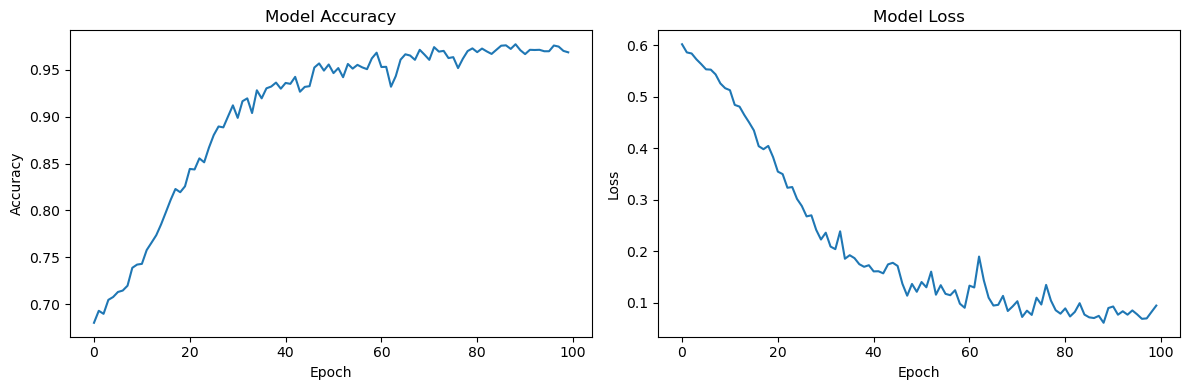

In [30]:
# Plot training accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()